In [21]:
import bilby
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from lalsimulation import SimNeutronStarEOSByName
import lalsimulation
import sys
import json 
import seaborn as sns
# Create KDE plot for both components
from scipy.stats import gaussian_kde

In [2]:
# This is the function that defines the universal relations 
def lambda_source_frame_mass_to_radius(source_frame_mass,the_lambda):
    
    # Define the Love-C coefficents
    c0 = 3.71e-1
    c1 = 3.91e-2
    c2 = 1.056e-3

    # Convert solar masses to km 
    # This is approximate and I will use the lalsim version latter.
    mass_km = source_frame_mass*1.48

    #Expression gives the radius in units of mass (km)
    radius = mass_km/(c0-c1*np.log(the_lambda)+c2*(np.log(the_lambda))**2.)
    return radius

In [3]:
# Add this function after your other function definitions
def get_eos_curves(eosname):
    """Get pressure and mass-radius curves for SLy EOS"""
    eos = SimNeutronStarEOSByName(eosname)
    # Get pressure curve
    # Get mass-radius curve
    eos_masses, eos_radii = calculate_mass_radius_curves(eos)
    return eos_masses, eos_radii

def calculate_mass_radius_curves(eos, masses=None):
    # Create neutron star eos family
    eos_family = lalsimulation.CreateSimNeutronStarFamily(eos)
    """Calculate radii for given EOS at specified masses"""
    if masses is None:
        masses = np.linspace(0.5, 3.0, 100)
    
    radii = []
    valid_masses = []
    
    for m in masses:
        try:
            r = lalsimulation.SimNeutronStarRadius(m * lalsimulation.lal.MSUN_SI, eos_family) / 1000.0  # Convert to km
            if np.isfinite(r):
                radii.append(r)
                valid_masses.append(m)
        except RuntimeError:
            continue
            
    return np.array(valid_masses), np.array(radii)

In [5]:
# Read in CSV files 
NSBH_samples = "GW190425_NSBH_posterior_samples.csv"
BNS_samples = "GW170817_posterior_samples.csv"
official_samples = "GW190425_official_posterior_samples.csv"


BNS_df = pd.read_csv(BNS_samples)
print(BNS_df)
NSBH_df = pd.read_csv(NSBH_samples)
official_df = pd.read_csv(official_samples)
mass_BNS = BNS_df['chirp_mass_source'].tolist()
tides_BNS = BNS_df['lambda_tilde'].tolist()
massratio_BNS = BNS_df['mass_ratio'].tolist()
mass_NSBH = NSBH_df['chirp_mass_source'].tolist()
tides_NSBH = NSBH_df['lambda_tilde'].tolist()
mass_official = official_df['chirp_mass_source'].tolist()
tides_official = official_df['lambda_tilde'].tolist()
print(massratio_BNS)


      chirp_mass_source  lambda_tilde  mass_ratio
0              1.184704    448.255531    0.861103
1              1.186353    651.506566    0.824989
2              1.190598    367.559035    0.873751
3              1.187826    702.972691    0.654496
4              1.188046    404.537038    0.975041
...                 ...           ...         ...
7706           1.188635    219.357249    0.877411
7707           1.189926    234.093181    0.922390
7708           1.188439    201.990395    0.783929
7709           1.190104    228.493019    0.854217
7710           1.188026    202.906937    0.718107

[7711 rows x 3 columns]
[0.8611030973578953, 0.8249889742527647, 0.873751215683573, 0.654495757328548, 0.975041020150651, 0.930621231402003, 0.9479796439219512, 0.828521741166035, 0.924450549446334, 0.8045518095009423, 0.9773826066248388, 0.8388555994362126, 0.9064376334507992, 0.7534114532575986, 0.8819433169786356, 0.903973286153714, 0.9393708947552988, 0.9279959098622028, 0.7659876009640695, 0

In [6]:
# Convert chirp mass and lambda tilde to lambda_1 and mass_1 source 
mass_1, mass_2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(BNS_df['chirp_mass_source'],BNS_df['mass_ratio'])
lambda_1, lambda_2 = bilby.gw.conversion.lambda_tilde_to_lambda_1_lambda_2(BNS_df['lambda_tilde'],mass_1,mass_2)

In [7]:
radius_1 = lambda_source_frame_mass_to_radius(mass_1, lambda_1) 
radius_2 = lambda_source_frame_mass_to_radius(mass_2, lambda_2) 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def make_kde_plot(x, y, color_name):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)

    # Evaluate KDE on original points
    density = kde(xy)

    # Sort points by density for better visualization
    idx = density.argsort()
    x, y, density = x[idx], y[idx], density[idx]

    #scatter = plt.scatter(x, y, c=density, cmap=plt.cm.get_cmap(color_name),
                          #alpha=0.5, s=1)

    # Define a grid over which to evaluate the KDE
    xg = np.linspace(x.min(), x.max(), 100)
    yg = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xg, yg)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kde(positions).T, X.shape)  # Evaluate KDE over grid

    # Sort all density values from highest to lowest
    sorted_Z = np.sort(Z.ravel())[::-1]  # Descending order
    cumulative_mass = np.cumsum(sorted_Z) / np.sum(sorted_Z)  # Normalize

    # Find the density threshold where cumulative mass first exceeds 90%
    threshold_idx = np.argmax(cumulative_mass >= 0.9)
    threshold = sorted_Z[threshold_idx]

    # Plot the 90% HDR contour
    plt.contour(X, Y, Z, colors='k', levels=[threshold], alpha=0.5, linestyles='--')
    plt.colorbar(scatter, label="Density")


In [54]:
def plot_density_with_ci(x, y,cmap,confidence=0.9):
    samples = np.vstack([x, y])
    
    samples = np.vstack([x, y])
    
    # Compute density
    kde = gaussian_kde(samples)
    x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
    z = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)
    
    # Compute highest-density confidence interval threshold
    z_sorted = np.sort(z.ravel())[::-1]  # Sort in descending order
    cumsum = np.cumsum(z_sorted) / np.sum(z_sorted)
    threshold = z_sorted[np.searchsorted(cumsum, confidence)]

    
    sns.kdeplot(x=x, y=y, fill=True, cmap=cmap,levels=200)
    #plt.contour(x_grid, y_grid, z, levels=[threshold], colors='black',linestyles='dashed', label=f'{int(confidence*100)}% CI')

In [58]:
import corner
def plot_corner_density(x, y, confidence=0.9):
    samples = np.vstack([x, y]).T
    
    # Create corner plot
    figure = corner.corner(samples, 
                            labels=["$R$ (km)", "$m$ ($M_\odot$)"],
                            plot_contours=True,
                            levels=[confidence],
                            bins=30,
                            hist_bin_factor=2,
                            smooth=1.0,
                            plot_datapoints=True,
                            fill_contours=True,
                            color='blue')
    
    plt.show()

In [68]:
def plot_corner_density(x, y, confidence=0.9):
    fig, ax = plt.subplots(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.05, wspace=0.05)
    main_ax = plt.subplot(grid[1:, :-1])
    x_hist = plt.subplot(grid[0, :-1], sharex=main_ax)
    y_hist = plt.subplot(grid[1:, -1], sharey=main_ax)
    
    # Compute density
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
    z = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)
    
    # Compute highest-density confidence interval threshold
    z_sorted = np.sort(z.ravel())[::-1]  # Sort in descending order
    cumsum = np.cumsum(z_sorted) / np.sum(z_sorted)
    threshold = z_sorted[np.searchsorted(cumsum, confidence)]
    
    # Main 2D density plot
    sns.kdeplot(x=x, y=y, fill=True, cmap='Blues', ax=main_ax)
    main_ax.contour(x_grid, y_grid, z, levels=[threshold], colors='red', linewidths=2)
    #main_ax.scatter(x, y, alpha=0.3, s=5, color='black')
    
    # Marginal histograms
    sns.histplot(x, bins=30, kde=True, color='Blue', ax=x_hist,element='step',fill=False)
    sns.histplot(y=y, bins=30, kde=True, color='gray', ax=y_hist)
    
    # Hide labels on histograms
    plt.setp(x_hist.get_xticklabels(), visible=False)
    plt.setp(y_hist.get_yticklabels(), visible=False)
    
    main_ax.set_xlabel("$R$ (km)")
    main_ax.set_ylabel("$m$ ($M_\odot$)")
    main_ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()

/var/folders/cg/0bw3vjvs2s3cc7cjt_43pps1jw1ghg/T/ipykernel_93903/3907619997.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  main_ax = plt.subplot(grid[1:, :-1])


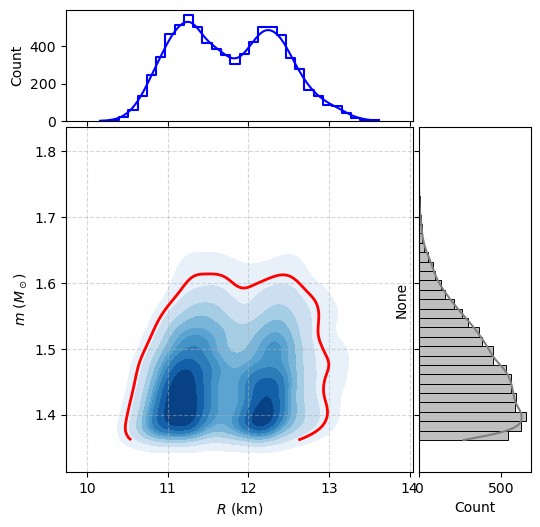

GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic 

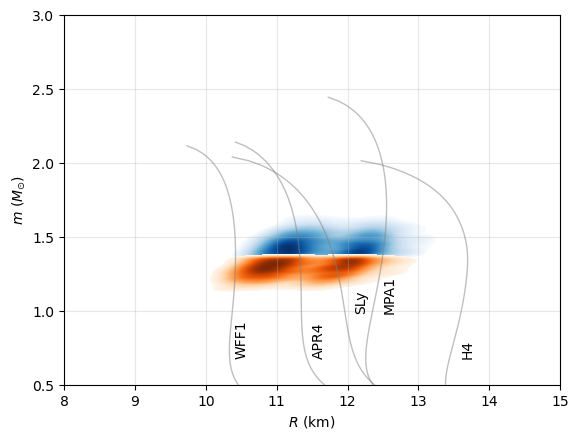

In [69]:
# Plot the distributions
#make_kde_plot(radius_1, mass_1, 'Blues')
#make_kde_plot(radius_2, mass_2, 'Oranges')
plot_corner_density(radius_1,mass_1)
plot_density_with_ci(radius_1,mass_1,'Blues')
plot_density_with_ci(radius_2,mass_2,'Oranges')

# Add BH and Buchdahl limits
x_bh = np.linspace(6, 15, 100)

sly_masses, sly_radii = get_eos_curves('SLy')
apr4_masses,apr4_radii = get_eos_curves('APR4_EPP')
mpa1_masses,mpa1_radii = get_eos_curves('MPA1')
wff1_masses,wff1_radii = get_eos_curves('WFF1')
h4_masses,h4_radii = get_eos_curves('H4')
# Formatting
plt.plot(sly_radii, sly_masses, 'k-', label='SLy', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(apr4_radii, apr4_masses, 'k-', label='APR4', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(mpa1_radii, mpa1_masses, 'k-', label='APR4', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(wff1_radii, wff1_masses, 'k-', label='WFF1', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(h4_radii, h4_masses, 'k-', label='H4', lw=1, zorder=10,color='gray',alpha=0.5)

plt.text(10.4, 0.7, 'WFF1', rotation=90)
plt.text(11.5, 0.7, 'APR4', rotation=90)
plt.text(12.1, 1.0, 'SLy', rotation=90)
plt.text(12.5, 1.0, 'MPA1', rotation=90)
plt.text(13.6,0.7,'H4', rotation=90)

plt.xlabel(r'$R \ (\rm km)$')
plt.ylabel(r'$m \ (M_{\odot})$')
plt.xlim(8, 15)
plt.ylim(0.5, 3.0)
plt.grid(True, alpha=0.3)

plt.savefig('GW170817_mass_radius_universalrel.pdf', dpi=500, bbox_inches='tight')

In [26]:
# No we repeat for GW190425 BNS
# Read in CSV files 
#NSBH_samples = "GW190425_NSBH_posterior_samples.csv"
BNS_samples = "GW190425_BNS_posterior_samples.csv"


BNS_df = pd.read_csv(BNS_samples)
NSBH_df = pd.read_csv(NSBH_samples)
official_df = pd.read_csv(official_samples)
mass_BNS = BNS_df['chirp_mass_source'].tolist()
tides_BNS = BNS_df['lambda_tilde'].tolist()
massratio_BNS = BNS_df['mass_ratio'].tolist()
mass_NSBH = NSBH_df['chirp_mass_source'].tolist()
tides_NSBH = NSBH_df['lambda_tilde'].tolist()
mass_official = official_df['chirp_mass_source'].tolist()
tides_official = official_df['lambda_tilde'].tolist()
print(massratio_BNS)

[0.9127181063425328, 0.7005800950866186, 0.8755148238791284, 0.75028906328582, 0.8996458620655777, 0.7203688842238454, 0.7280349400824699, 0.9529572155808193, 0.9271488890560652, 0.8698805445660761, 0.9339751218136244, 0.7821461493291711, 0.8591366429063929, 0.7705353461311133, 0.9116919720522444, 0.8393902774949137, 0.8481660266759667, 0.7637925268571123, 0.9740089658089526, 0.6464382694463444, 0.8954875747935702, 0.9915580434902715, 0.7260916656108615, 0.8819742829123299, 0.9045253509462318, 0.8076899311690944, 0.8459481953157062, 0.7703059332209898, 0.7052900222281885, 0.8919897296544537, 0.9324221105186776, 0.8274891938345103, 0.7342927463203882, 0.968869881727, 0.9171250540523735, 0.977598848650792, 0.9788101760310516, 0.9546965286845264, 0.930760096131054, 0.9422385570112796, 0.7496652213581518, 0.755463331147485, 0.9745847192665636, 0.8798456379442664, 0.8949930067692804, 0.7923170688126169, 0.9090995705966572, 0.7157538848665966, 0.8714197142410133, 0.8438630380801401, 0.867150

In [29]:
# Convert chirp mass and lambda tilde to lambda_1 and mass_1 source 
mass_1, mass_2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(BNS_df['chirp_mass_source'],BNS_df['mass_ratio'])
lambda_1, lambda_2 = bilby.gw.conversion.lambda_tilde_to_lambda_1_lambda_2(BNS_df['lambda_tilde'],mass_1,mass_2)

In [28]:
radius_1 = lambda_source_frame_mass_to_radius(mass_1, lambda_1) 
radius_2 = lambda_source_frame_mass_to_radius(mass_2, lambda_2) 

/var/folders/cg/0bw3vjvs2s3cc7cjt_43pps1jw1ghg/T/ipykernel_98331/1157038493.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x, y, c=density, cmap=plt.cm.get_cmap(color_name),
/var/folders/cg/0bw3vjvs2s3cc7cjt_43pps1jw1ghg/T/ipykernel_98331/1157038493.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x, y, c=density, cmap=plt.cm.get_cmap(color_name),
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: inter

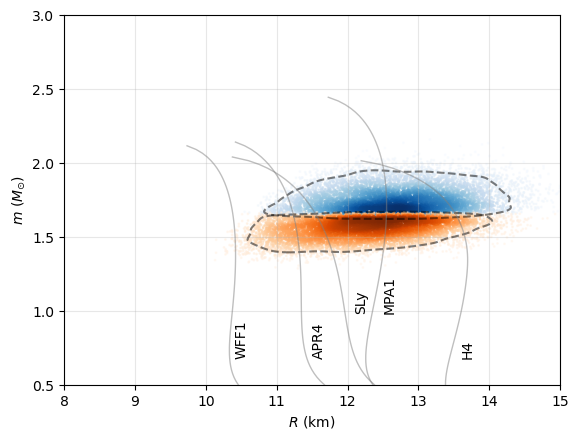

In [30]:
# Plot the distributions
make_kde_plot(radius_1, mass_1, 'Blues')
make_kde_plot(radius_2, mass_2, 'Oranges')

# Add BH and Buchdahl limits
x_bh = np.linspace(6, 15, 100)

sly_masses, sly_radii = get_eos_curves('SLy')
apr4_masses,apr4_radii = get_eos_curves('APR4_EPP')
mpa1_masses,mpa1_radii = get_eos_curves('MPA1')
wff1_masses,wff1_radii = get_eos_curves('WFF1')
h4_masses,h4_radii = get_eos_curves('H4')
# Formatting
plt.plot(sly_radii, sly_masses, 'k-', label='SLy', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(apr4_radii, apr4_masses, 'k-', label='APR4', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(mpa1_radii, mpa1_masses, 'k-', label='APR4', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(wff1_radii, wff1_masses, 'k-', label='WFF1', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(h4_radii, h4_masses, 'k-', label='H4', lw=1, zorder=10,color='gray',alpha=0.5)

plt.text(10.4, 0.7, 'WFF1', rotation=90)
plt.text(11.5, 0.7, 'APR4', rotation=90)
plt.text(12.1, 1.0, 'SLy', rotation=90)
plt.text(12.5, 1.0, 'MPA1', rotation=90)
plt.text(13.6,0.7,'H4', rotation=90)

plt.xlabel(r'$R \ (\rm km)$')
plt.ylabel(r'$m \ (M_{\odot})$')
plt.xlim(8, 15)
plt.ylim(0.5, 3.0)
plt.grid(True, alpha=0.3)

plt.savefig('GW190425_mass_radius_universalrel.pdf', dpi=500, bbox_inches='tight')

In [50]:
# Now do the NSBH 
# No we repeat for GW190425 BNS
# Read in CSV files 
#NSBH_samples = "GW190425_NSBH_posterior_samples.csv"
NSBH_samples = "GW190425_NSBH_posterior_samples.csv"



NSBH_df = pd.read_csv(NSBH_samples)


mass_NSBH = NSBH_df['chirp_mass_source'].tolist()
tides_NSBH = NSBH_df['lambda_tilde'].tolist()
massratio_NSBH = NSBH_df['mass_ratio'].tolist()


In [42]:
# Define a special conversion function for NSBH mergers 
def lambda_tilde_to_lambda_1_lambda_2_NSBH(
        lambda_tilde, mass_1, mass_2):
    """
    Convert from dominant tidal term to individual tidal parameters
    assuming lambda_1 = 0. 

    See, e.g., Wade et al., https://arxiv.org/pdf/1402.5156.pdf.

    Parameters
    ==========
    lambda_tilde: float
        Dominant tidal term.
    mass_1: float
        Mass of more massive neutron star.
    mass_2: float
        Mass of less massive neutron star.

    Returns
    =======
    lambda_1: float
        Tidal parameter of more massive neutron star.
    lambda_2: float
        Tidal parameter of less massive neutron star.
    """
    #print("Calling conversion function")
    eta = bilby.gw.conversion.component_masses_to_symmetric_mass_ratio(mass_1, mass_2)
    coefficient = (1 + 7 * eta - 31 * eta**2) - (1 - 4 * eta)**0.5 * (1 + 9 * eta - 11 * eta**2)
    lambda_1 = 0.0
    lambda_2 = 13 / 8 * lambda_tilde / coefficient
    
    return lambda_1, lambda_2

In [51]:
# Convert chirp mass and lambda tilde to lambda_1 and mass_1 source 
mass_1, mass_2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(NSBH_df['chirp_mass_source'],NSBH_df['mass_ratio'])
print(mass_1)
lambda_1, lambda_2 = lambda_tilde_to_lambda_1_lambda_2_NSBH(NSBH_df['lambda_tilde'],mass_1,mass_2)

0       1.716231
1       1.906939
2       1.713167
3       1.849204
4       1.932619
          ...   
7333    1.793067
7334    1.850354
7335    1.747863
7336    1.833954
7337    1.725517
Length: 7338, dtype: float64


In [52]:
#radius_1 = lambda_source_frame_mass_to_radius(mass_1, lambda_1) 
radius_2 = lambda_source_frame_mass_to_radius(mass_2, lambda_2) 

/var/folders/cg/0bw3vjvs2s3cc7cjt_43pps1jw1ghg/T/ipykernel_98331/1157038493.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(x, y, c=density, cmap=plt.cm.get_cmap(color_name),
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure
GSL function failed: interpolation error (errnum=1)
XLAL Error - 

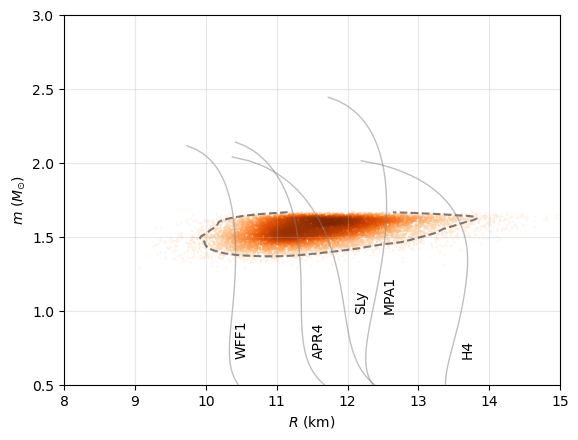

In [53]:
# Plot the distributions
#make_kde_plot(radius_1, mass_1, 'Blues')
make_kde_plot(radius_2, mass_2, 'Oranges')

# Add BH and Buchdahl limits
x_bh = np.linspace(6, 15, 100)

sly_masses, sly_radii = get_eos_curves('SLy')
apr4_masses,apr4_radii = get_eos_curves('APR4_EPP')
mpa1_masses,mpa1_radii = get_eos_curves('MPA1')
wff1_masses,wff1_radii = get_eos_curves('WFF1')
h4_masses,h4_radii = get_eos_curves('H4')
# Formatting
plt.plot(sly_radii, sly_masses, 'k-', label='SLy', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(apr4_radii, apr4_masses, 'k-', label='APR4', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(mpa1_radii, mpa1_masses, 'k-', label='APR4', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(wff1_radii, wff1_masses, 'k-', label='WFF1', lw=1, zorder=10,color='gray',alpha=0.5)
plt.plot(h4_radii, h4_masses, 'k-', label='H4', lw=1, zorder=10,color='gray',alpha=0.5)

plt.text(10.4, 0.7, 'WFF1', rotation=90)
plt.text(11.5, 0.7, 'APR4', rotation=90)
plt.text(12.1, 1.0, 'SLy', rotation=90)
plt.text(12.5, 1.0, 'MPA1', rotation=90)
plt.text(13.6,0.7,'H4', rotation=90)

plt.xlabel(r'$R \ (\rm km)$')
plt.ylabel(r'$m \ (M_{\odot})$')
plt.xlim(8, 15)
plt.ylim(0.5, 3.0)
plt.grid(True, alpha=0.3)

plt.savefig('GW190425_mass_radius_universalrel_NSBH.pdf', dpi=500, bbox_inches='tight')